# Filter comparison on LOD variation

## First, required libraries are loaded

In [1]:
import pandas as pd
from matplotlib.pyplot import *
import math
import numpy as np
from scipy import signal
from mssa_toolbox import *
#plt.style.use('dark_background') #uncomment for sensitive eyes
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (12, 7)
#Parameters:
fs = 365 #daily sampling frequency = 365 cpy

## Data is read and loaded from file

In [2]:
datf = pd.read_csv("Data.csv") #Quick csv of lod is used for exemple
datf.head(5) #will show the first five lnes of the data file

,LOD
0,2.5319
1,2.5864
2,2.6674
3,2.7494
4,2.8136


## Signal plot

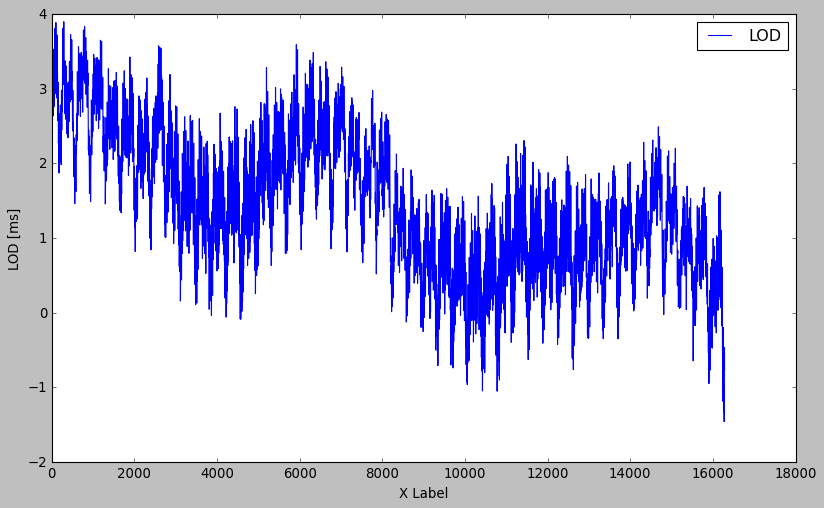

In [3]:
x = np.arange(len(datf))
sig = datf.LOD.copy()
plt.figure()
plt.plot(x,sig, c = 'b', label = 'LOD')
plt.xlabel('X Label')
plt.ylabel('LOD [ms]');
plt.legend(loc="upper right");

## Seasonal signal removal

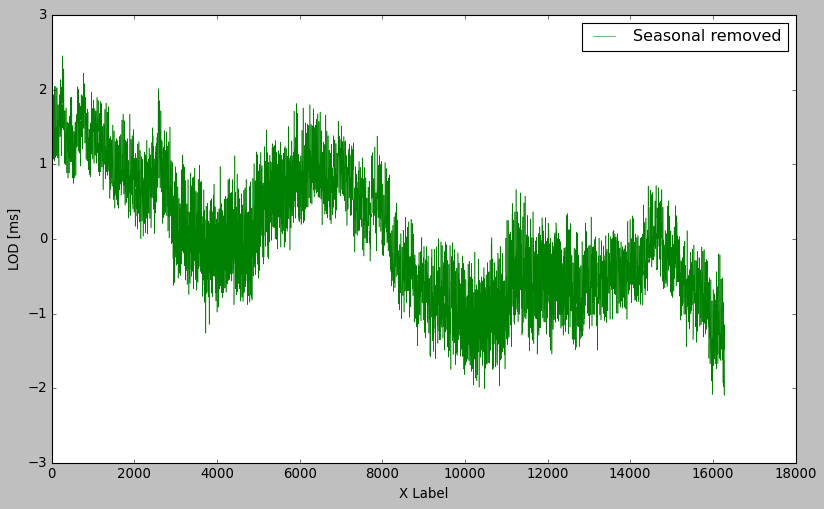

In [4]:
for k in range(365): #average seasonal component
    sig[k::365]-=sig[k::365].mean()
fig, ax = subplots()
ax.plot(x, sig, 'g', label = 'Seasonal removed', lw = 0.5)
ax.set_xlabel ('X Label')
ax.set_ylabel ('LOD [ms]')
ax.legend();

## Low pass filtering using a 2nd order butterworth filter

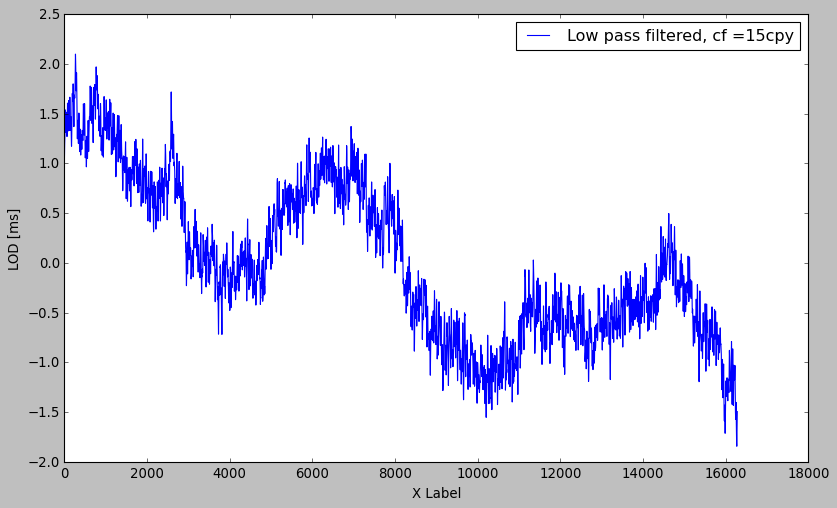

In [5]:
cf = 15 #in cpy
order = 2
sos = signal.butter(order, cf, 'low', fs = fs, output = 'sos')
sig  = signal.sosfiltfilt(sos, sig)

#Plot
fig, ax = subplots()
ax.plot(x, sig, label = 'Low pass filtered, cf ={}cpy'.format(cf), lw = 1)
ax.set_xlabel ('X Label')
ax.set_ylabel ('LOD [ms]')
ax.legend();

## Size reduction

Signal size is reduced to one sample every five days

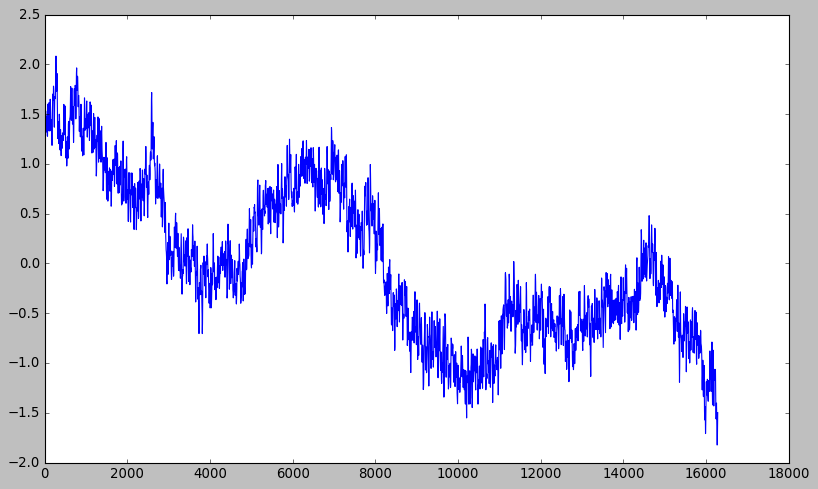

In [6]:
sper = 5 #Sample period in days 
ssasig = sig[::sper].copy()
ssax = x[::sper].copy()
plot(ssax,ssasig);

# SSA decomposition

## Round zero to "detrend" the signal

A first SSA is used to remove the first component of very low frequency

In [7]:
#Parameters
winy = 9 #window size in years
lmcssa = 100
NumComp = 15

Text(0, 0.5, 'LOD [ms]')

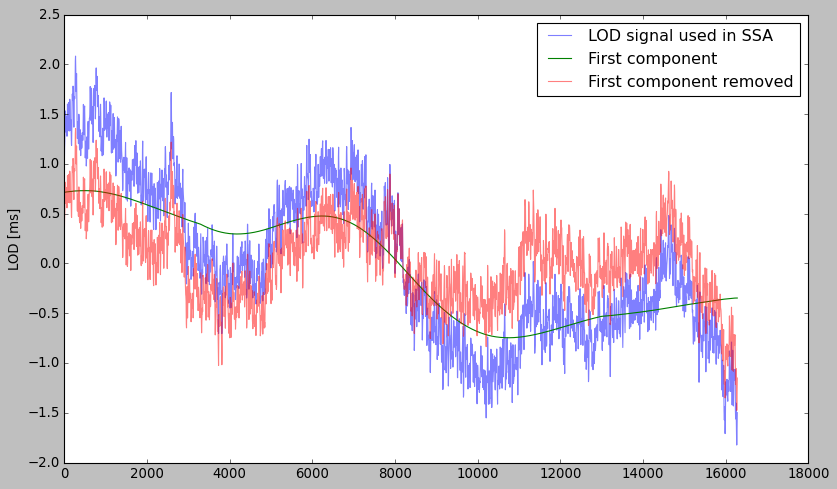

In [8]:
V,D,pc,R=ssa(ssasig,M=int(winy*365.25/sper),Nc=8)
ssasigf = ssasig - R[:,0]
fig, ax = subplots()
ax.plot(ssax,ssasig, alpha=0.5, c='b', label='LOD signal used in SSA')
ax.plot(ssax, R[:,0], alpha=1, c='g', label='First component')
ax.plot(ssax,ssasigf, alpha=0.5, c='r', label='First component removed')
ax.legend(loc=1);
ax.set_ylabel('LOD [ms]')

## First round of SSA

In [9]:
Dd,Ds,F   =mcssa(ssasigf,M=int(winy*365.25/sper),N=lmcssa)
F[F==0]=1/(ssax[-1]-ssax[0])/2*365.25
V,D,pc,R=ssa(ssasigf,M=int(winy*365.25/sper),Nc=NumComp)

Round 1
Component number:  0  cpy:  0.06723979121891312  Period in years:  14.87214611872146
Component number:  1  cpy:  0.06723979121891312  Period in years:  14.87214611872146


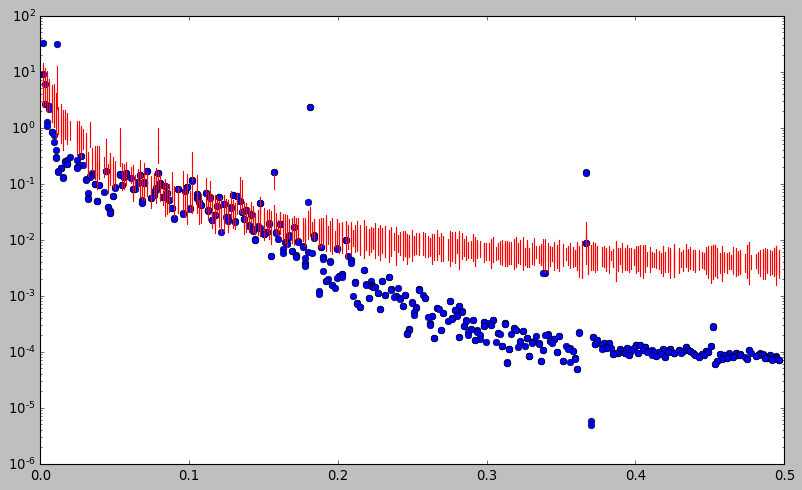

In [10]:
semilogy(F,Dd,'o', label = 'Variance capturée')
fr=np.fft.fftfreq(len(ssasigf),sper/365)[:len(ssasigf)//2]
fr[fr==0] = 1/42
per = 1/fr
T = []
C = []

ssasigr2 = np.copy(ssasigf)
print('Round 1')
for k in range(Ds.shape[0]):
    sD=sort(Ds[k,:])
    k025=sD[int(lmcssa*0.025)]
    k975=sD[int(lmcssa*0.975)]
    plt.plot([F[k],F[k]],[k025,k975],'r', label = 'Bruit')
    if (D[k]>k975) & (k<NumComp):
        fk=np.fft.fft(R[:,k])[:len(fr)]
        Tk=per[np.argmax(abs(fk))]
        if Tk > 1:
            print('Component number: ',k,' cpy: ',1/Tk,
                  ' Period in years: ',Tk)
            C.append(R[:,k])
            T.append(Tk)
        ssasigr2-=R[:,k]

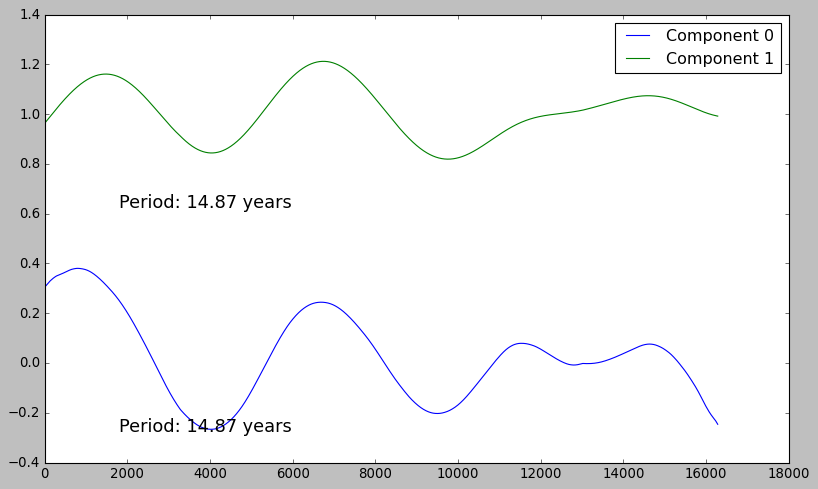

In [11]:
fig, ax = subplots()
Lc=len(C)
for k in range(Lc):
    ax.plot(ssax,C[k]+k, label = 'Component {}'.format(k))
    ax.text(0.1, k/Lc+0.07, 'Period: {:.2f} years'.format(T[k]), transform=ax.transAxes,  fontsize=16)
ax.legend(loc=1);

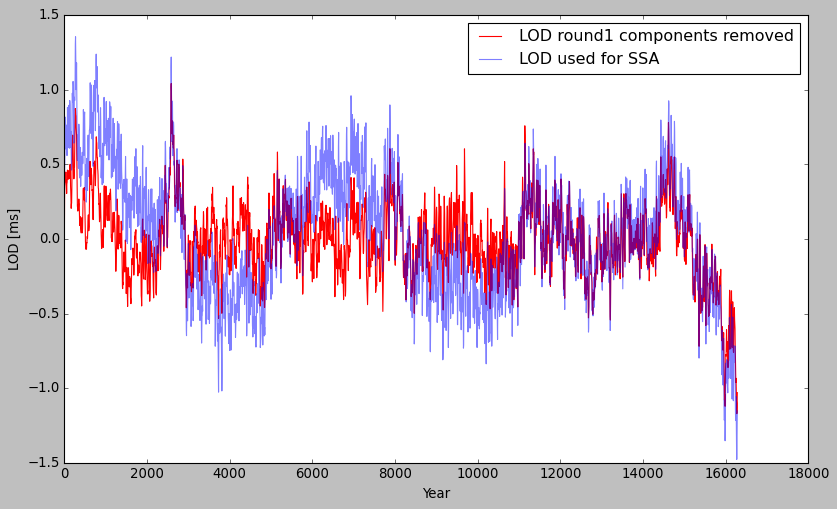

In [12]:
fig, ax = subplots()
ax.plot(ssax,ssasigr2, alpha=1, c='r', label='LOD round1 components removed')
ax.plot(ssax,ssasigf, alpha=0.5, c='b', 
        label='LOD used for SSA')
ax.legend(loc=1);
ax.set_ylabel('LOD [ms]')
ax.set_xlabel('Year');

## Second round of SSA

In [13]:
Dd,Ds,F   =mcssa(ssasigr2,M=int(winy*365.25/sper),N=lmcssa)
V,D,pc,R=ssa(ssasigr2,M=int(winy*365.25/sper),Nc=NumComp)
F[F==0]=1/(ssax[-1]-ssax[0])/2*365

Round 2
Component number:  0  cpy:  0.13447958243782623  Period in years:  7.43607305936073
Component number:  1  cpy:  0.15689284617746393  Period in years:  6.3737769080234825


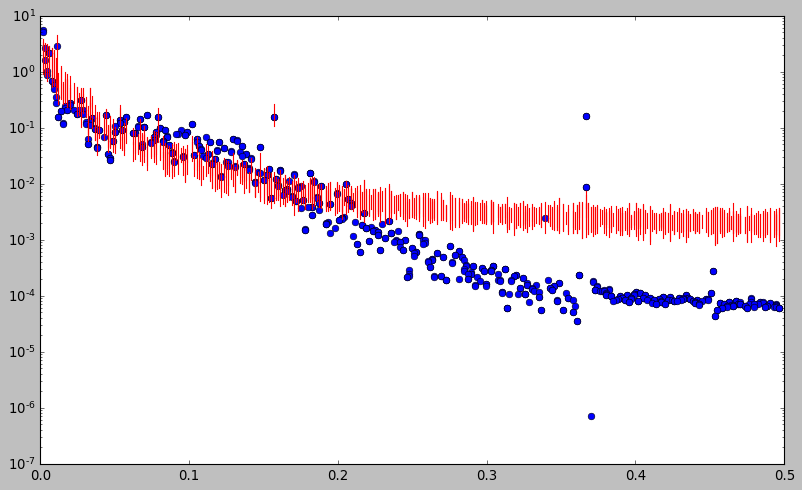

In [14]:
semilogy(F,Dd,'o')
li2=[]
ssasigr3=copy(ssasigr2)
print('Round 2')
for k in range(D.shape[0]):
    sD=sort(Ds[k,:])
    k025=sD[int(lmcssa*0.025)]
    k975=sD[int(lmcssa*0.975)]
    plot([F[k],F[k]],[k025,k975],'r')
    if (D[k]>k975) & (k<NumComp):
        fk=np.fft.fft(R[:,k])[:len(fr)]
        Tk=per[np.argmax(abs(fk))]
        if Tk > 1:
            print('Component number: ',k,' cpy: ',1/Tk,
                  ' Period in years: ',Tk)
            C.append(R[:,k])
            T.append(Tk)
        ssasigr3-=R[:,k]

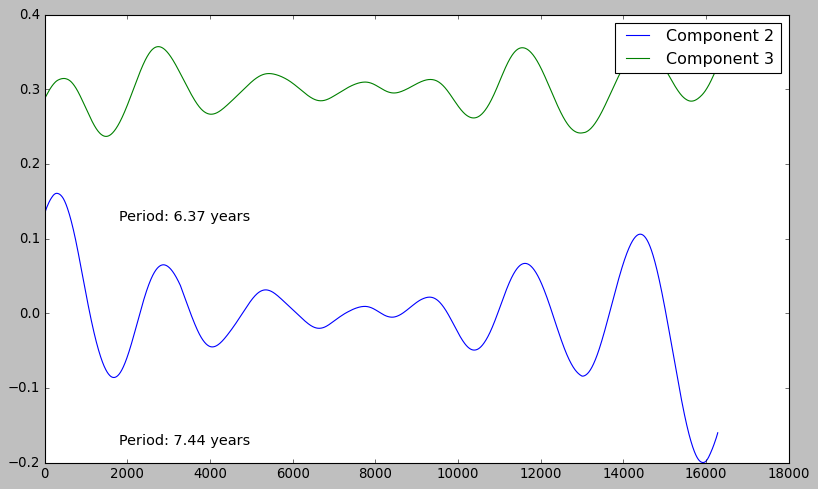

In [15]:
fig, ax = subplots()
for k in range(Lc,len(C)):
    ax.plot(ssax,C[k]+0.3*(k-Lc), label = 'Component {}'.format(k))
    ax.text(0.1, (k-Lc)/(len(C)-Lc)+0.04, 'Period: {:.2f} years'.format(T[k])
            ,transform=ax.transAxes,  fontsize=13)
ax.legend(loc=1);
Lc=len(C)

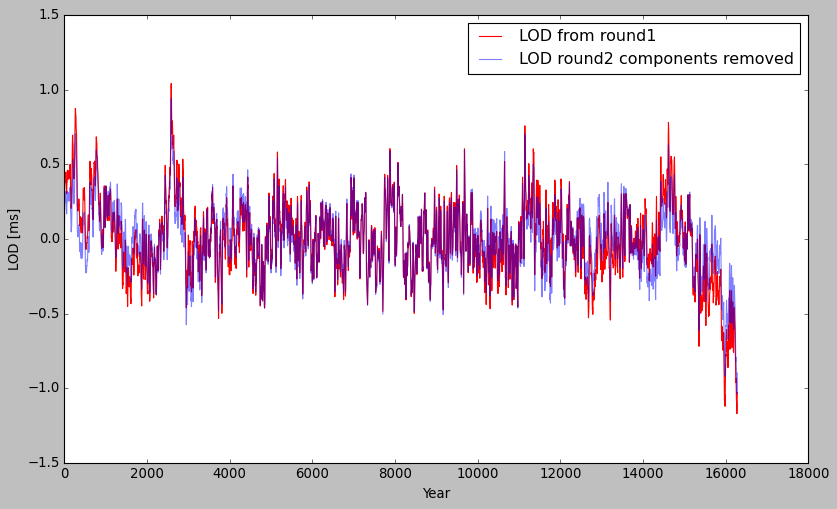

In [16]:
fig, ax = subplots()
ax.plot(ssax,ssasigr2, alpha=1, c='r', label='LOD from round1')
ax.plot(ssax,ssasigr3, alpha=0.5, c='b', 
        label='LOD round2 components removed')
ax.legend(loc=1);
ax.set_ylabel('LOD [ms]')
ax.set_xlabel('Year');